In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from numpy import asarray
import torch
from os import listdir
from PIL import Image
import os
import matplotlib.pyplot as plt

def load_images(path):


    src_ls = []
    tar_ls = []

    for images in listdir(path):
        images = os.path.join(path,images)
        img = Image.open(images)

        img_np = np.array(img)

        src , tar = img_np[: ,:600] , img_np[:,600:]

        src_img = Image.fromarray(src).resize((256,256))
        tar_img = Image.fromarray(tar).resize((256,256))

        src_img = np.array(src_img)/255.0
        tar_img = np.array(tar_img)/255.0

        src = torch.tensor(src_img, dtype=torch.float32).permute(2,0,1)
        tar = torch.tensor(tar_img,dtype=torch.float32).permute(2,0,1)
        src_ls.append(src)
        tar_ls.append(tar)

    return [asarray(src_ls) , asarray(tar_ls)]

path = "/content/drive/MyDrive/maps/train"
[src , tar] = load_images(path)

In [3]:
print(src.shape)
print(tar.shape)

(1096, 3, 256, 256)
(1096, 3, 256, 256)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
#pix2pix_model
import numpy as np
from numpy.random import randint
import torch
from torch import nn
import torch.optim as optim

class Discriminator(nn.Module):
  def __init__(self , input_channels = 3):
    super().__init__()

    def init_weights(layer):
      if isinstance(layer , nn.Conv2d) or isinstance(layer , nn.BatchNorm2d):
        nn.init.normal_(layer.weight , 0.0 , 0.02)

    self.model = nn.Sequential(
        #64
        nn.Conv2d(input_channels*2 , 64 , kernel_size=4 , stride=2 , padding=1),
        nn.LeakyReLU(0.2,inplace=True),

        #128
        nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),

        #256
        nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),

        #512
        nn.Conv2d(256,512,kernel_size=4 , stride=1 , padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),

        #512
        nn.Conv2d(512,512,kernel_size=4 , stride=1 , padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),

        #1
        nn.Conv2d(512,1,kernel_size = 4 ,padding=2),
        nn.Sigmoid()
    )
    self.model.apply(init_weights)

  def forward(self,x):
    return self.model(x)



class Generator(nn.Module):
  def __init__(self, input_channels = 3 , output_channels = 3) -> None:
    super().__init__()

    def init_weight(layer):
      if isinstance(layer , nn.Conv2d) or isinstance(layer , nn.ConvTranspose2d):
        nn.init.normal_(layer.weight , 0 , 0.2)


    def downsample(in_channels , out_channels , apply_batchnorm = True):
      layer = [nn.Conv2d(in_channels , out_channels , kernel_size=4 , stride = 2 , padding=1)]
      if apply_batchnorm:
        layer.append(nn.BatchNorm2d(out_channels))
      layer.append(nn.LeakyReLU(0.2,inplace=True))
      return nn.Sequential(*layer)

    def upsample(in_channels , out_channels , dropout = False):
      layer = [nn.ConvTranspose2d(in_channels , out_channels , kernel_size=4 , stride=2 , padding=1),
               nn.BatchNorm2d(out_channels),
               nn.ReLU(inplace = True)
               ]
      if dropout:
        layer.append(nn.Dropout(0.5))

      return nn.Sequential(*layer)

    self.enc1 = downsample(input_channels , 64 , apply_batchnorm = False)
    self.enc2 = downsample(64, 128)
    self.enc3 = downsample(128, 256)
    self.enc4 = downsample(256, 512)
    self.enc5 = downsample(512, 512)
    self.enc6 = downsample(512, 512)
    self.enc7 = downsample(512, 512)
    self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

    self.dec1 = upsample(512,512,dropout=True)
    self.dec2 = upsample(1024,512,dropout=True)
    self.dec3 = upsample(1024,512,dropout=True)
    self.dec4 = upsample(1024,512)
    self.dec5 = upsample(1024,256)
    self.dec6 = upsample(512,128)
    self.dec7 = upsample(256,64)
    self.final = nn.Sequential(
         nn.ConvTranspose2d(128 , output_channels , kernel_size=4 , stride=2 , padding=1),
         nn.Tanh()
     )

    self.apply(init_weight)

  def forward(self,x):
      enc1 = self.enc1(x)
      enc2 = self.enc2(enc1)
      enc3 = self.enc3(enc2)
      enc4 = self.enc4(enc3)
      enc5 = self.enc5(enc4)
      enc6 = self.enc6(enc5)
      enc7 = self.enc7(enc6)
      bottleneck = self.bottleneck(enc7)

      dec1 = self.dec1(bottleneck)
      dec2 = self.dec2(torch.cat([dec1,enc7],dim=1))
      dec3 = self.dec3(torch.cat([dec2,enc6],dim=1))
      dec4 = self.dec4(torch.cat([dec3,enc5],dim=1))
      dec5 = self.dec5(torch.cat([dec4,enc4],dim=1))
      dec6 = self.dec6(torch.cat([dec5,enc3],dim=1))
      dec7 = self.dec7(torch.cat([dec6,enc2],dim=1))
      return self.final(torch.cat([dec7,enc1],dim=1))





gen = Generator().to(device)
disc = Discriminator().to(device)

ad_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

gen_optim = optim.Adam(gen.parameters(),lr=0.002,betas=(0.5,0.999))
disc_optim = optim.Adam(disc.parameters(),lr=0.002,betas=(0.5,0.999))

def train_disc(real_x , condt_x , fake_x):
    real_labels = torch.ones((real_x.size(0), 1, 31, 31)).to(real_x.device)
    fake_labels = torch.zeros((fake_x.size(0), 1, 31, 31)).to(fake_x.device)

    rome = torch.cat([condt_x,real_x],dim=1)
    romef = torch.cat([condt_x,fake_x],dim=1)

    disc_optim.zero_grad()

    real_pred = disc(rome)
    fake_pred = disc(romef)

    real_loss = ad_loss(real_pred,real_labels)
    fake_loss = ad_loss(fake_pred , fake_labels)

    loss = (real_loss + fake_loss)*0.5
    loss.backward()
    disc_optim.step()

    return loss

def train_gen(real_x , condt_x):

    real_labels = torch.ones((real_x.size(0),1,31,31)).to(real_x.device)

    gen_optim.zero_grad()
    fake_x = gen(condt_x)
    rome = torch.cat([condt_x , fake_x],dim = 1)
    pred = disc(rome)
    adloss = ad_loss(pred,real_labels)
    l1loss = l1_loss(fake_x , real_x)*100
    gen_loss = adloss + l1loss
    gen_loss.backward()
    gen_optim.step()

    return gen_loss , fake_x



In [6]:
data = [src , tar]

In [7]:
from torch.utils.data import DataLoader , TensorDataset

data = TensorDataset(torch.from_numpy(src), torch.from_numpy(tar))
dataloader = DataLoader(data , batch_size = 16 , shuffle = True)




In [8]:
gen_loss = []
disc_loss = []
fake_img =[]
bt =0
epochs = 25

for epoch in range(epochs):
  gen10 = 0
  disc10 =0
  for batch , (condt_x , real_x) in enumerate(dataloader):
    condt_x = condt_x.to(device)
    real_x = real_x.to(device)
    fake_x = gen(condt_x)
    discl = train_disc(real_x,condt_x,fake_x)
    genl , fake_x1 = train_gen(real_x , condt_x)
    gen10 += genl.item()
    disc10 += discl.item()
    bt+=1

  avg_gen = gen10/bt
  avg_disc = disc10/bt
  gen_loss.append(avg_gen)
  disc_loss.append(avg_disc)

  print(f"Epochs : ({epoch+1}/{epochs}) | Generator loss : {gen_loss} | Discriminator loss : {disc_loss} ")




Epochs : (1/25) | Generator loss : [12.550297543622445] | Discriminator loss : [0.5646439311297043] 
Epochs : (2/25) | Generator loss : [12.550297543622445, 4.137732930805372] | Discriminator loss : [0.5646439311297043, 0.2867945542262084] 
Epochs : (3/25) | Generator loss : [12.550297543622445, 4.137732930805372, 2.4148966079748773] | Discriminator loss : [0.5646439311297043, 0.2867945542262084, 0.20597052473376914] 
Epochs : (4/25) | Generator loss : [12.550297543622445, 4.137732930805372, 2.4148966079748773, 1.7886781554291213] | Discriminator loss : [0.5646439311297043, 0.2867945542262084, 0.20597052473376914, 0.11868225715622521] 
Epochs : (5/25) | Generator loss : [12.550297543622445, 4.137732930805372, 2.4148966079748773, 1.7886781554291213, 1.3918224072110825] | Discriminator loss : [0.5646439311297043, 0.2867945542262084, 0.20597052473376914, 0.11868225715622521, 0.12279738161874854] 
Epochs : (6/25) | Generator loss : [12.550297543622445, 4.137732930805372, 2.4148966079748773

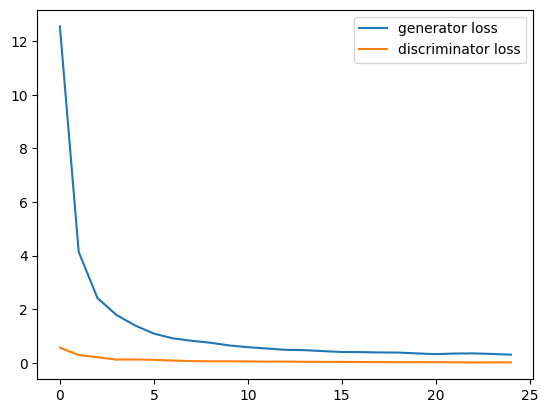

In [9]:
import matplotlib.pyplot as plt
plt.plot(gen_loss , label = "generator loss")
plt.plot(disc_loss , label = "discriminator loss")
plt.legend()
plt.show()

In [10]:
fake_x11 = []
for _ , (condt_x , real_x) in enumerate(dataloader):
  condt_x = condt_x.to(device)
  real_x = real_x.to(device)
  fake_x = gen(condt_x)
  fake_x11.append(fake_x.detach().cpu().numpy())

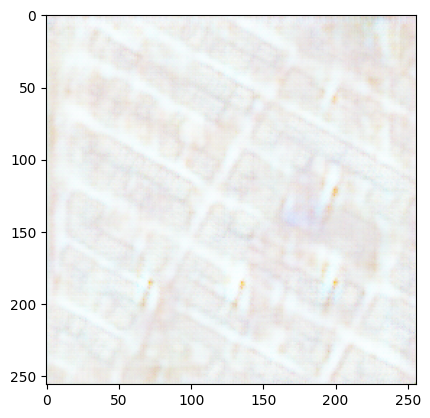

In [14]:
j=0
for i in fake_x11:
  # Convert the NumPy array back to a PyTorch tensor
  if j==1:
    i_tensor = torch.from_numpy(i[0])
    plt.imshow(i_tensor.permute(1,2,0))
    plt.show()
  j+=1
